Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as k-means clustering, which is implemented in sklearn.cluster.KMeans.
# Introduction
The k-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

*   The “cluster centre” is the arithmetic mean of all the points belonging to the cluster.
*   Each point is closer to its cluster centre than to other cluster centres.


Those two assumptions are the basis of the k-means model. We will soon dive into exactly how the algorithm reaches this solution, but for now, let’s take a look at a simple dataset and see the k-means result.

First, let’s generate a two-dimensional dataset containing four distinct blobs. To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


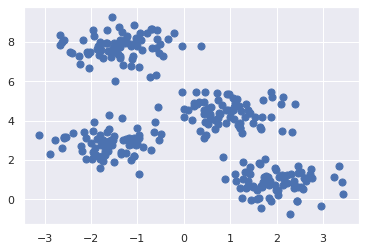

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

By eye, it is relatively easy to pick out the four clusters. The k-means algorithm does this automatically, and in Scikit-Learn uses the standard estimator API:



In [3]:
from sklearn.cluster import KMeans
kmeans =KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans=kmeans.predict(X)

Let’s visualize the results by plotting the data coloured by these labels. We will also plot the cluster centers as determined by the k-means estimator:

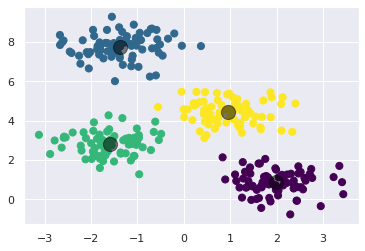

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

The good news is that the k-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.

But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the name of data points—an exhaustive search would be very, very costly. Fortunately for us, such a thorough search is not necessary: instead, the typical approach to k-means involves an intuitive, iterative approach known as expectation–maximization.

#k-Means Algorithm: Expectation–Maximization
Expectation–maximization (E–M) is a robust algorithm that comes up in a variety of contexts within data science. k-means is a particularly easy-to-understand and straightforward application of the algorithm, and we will walk through it briefly here. In short, the expectation-maximization approach here consists of the following procedure:



*   Guess some cluster centers

*   Repeat until converged


       1.E-Step: assign points to the nearest cluster center

       2.M-Step: set the cluster centers to the mean

Here the “E-step” or “Expectation step” is so-named because it involves updating our expectation of which cluster each point belongs to. The “M-step” or “Maximization step” is so-named because it consists in maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The k-Means algorithm is simple enough that we can write it in a few lines of code. The following is a very basic implementation:

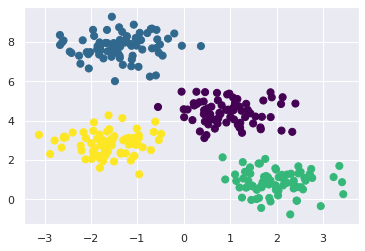

In [7]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')


# Example: K-Means Algorithm on Digits
To start, let’s take a look at applying k-means on the same simple digits data. Here we will attempt to use k-means to try to identify similar digits without using the original label information; this might be similar to a first step in extracting meaning from a new dataset about which you don’t have any a priori label information.

We will start by loading the digits and then finding the KMeans clusters. Recall that the numbers consist of 1,797 samples with 64 features, where each of the 64 elements is the brightness of one pixel in an 8×8 image:

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [10]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions. Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the “typical” digit within the cluster. Let’s see what these cluster centers look like:

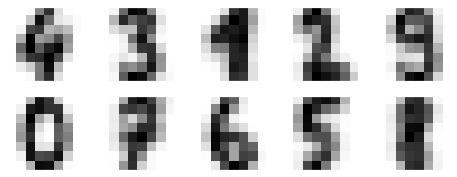

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that even without the labels, KMeans can find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because k-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted. We can fix this by matching each learned cluster label with the correct names found in them:

In [12]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [14]:
from sklearn.metrics import accuracy_score
print(" Accuracy Score:", accuracy_score(digits.target, labels))

 Accuracy Score: 0.7952142459654981


With just a simple k-means algorithm, we discovered the correct grouping for 80% of the input digits! Let’s check the confusion matrix for this:

Text(89.18, 0.5, 'predicted label')

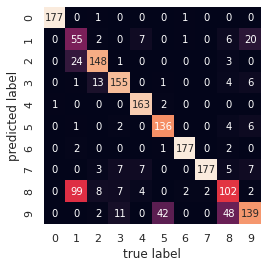

In [15]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones. But this still shows that using k-means, we can essentially build a digit classifier without reference to any known labels.